In [5]:
import pandas as pd
import numpy as np
import os
import GPy
import contextlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


### Read in synthetic data

In [6]:
folder_path = '../Emulation'

In [7]:
# Read Input Data
df_x = pd.read_csv(f'{folder_path}/Input/input_100.csv')

# Select varying inputs only
#columns_with_multiple_values = df_x.nunique() > 1
#filtered_input = df_x.loc[:, columns_with_multiple_values]

# Select only first 5 inputs 
filtered_input = df_x.iloc[:,:5]

dataframes = {}

# Read PCA data
for i in range(3):
    df_name = f'y_PC{i+1}'  # Create the dataframe name
    dataframes[df_name] = pd.read_csv(f'{folder_path}/Outputs/Out_fixed/PCA/PC{i+1}.csv')  # Read and store the dataframe
    
PC1 = dataframes['y_PC1']
PC2 = dataframes['y_PC2']
PC3 = dataframes['y_PC3']

df_pressure = pd.read_csv(f'{folder_path}/Outputs/Out_fixed/pressure_traces_r_pat/all_pressure_traces.csv')

CO = df_pressure.iloc[:,100:101]
dt = df_pressure['dt']
mean_press = df_pressure.iloc[:,:100].mean(axis=1).to_frame(name='mean_press')
max_press = df_pressure.iloc[:,:100].max(axis=1).to_frame(name='max_press')
min_press = df_pressure.iloc[:,:100].min(axis=1).to_frame(name='min_press')


### Take a look and input true input X 

In [8]:
filtered_input

,# svn.c,pat.r,pat.c,rv.E_act,T
0,27.687002,0.443723,3.278327,1.623082,0.478369
1,10.935100,0.243385,4.286711,2.717826,0.805784
2,18.671167,0.356841,2.549143,0.822205,0.950488
3,24.992088,0.155291,5.101243,3.333386,0.614289
4,22.700741,0.326891,3.862239,2.779415,0.551895
...,...,...,...,...,...
95,27.406567,0.196824,3.333852,1.704984,0.646159
96,26.960391,0.395660,2.043640,0.645535,0.810764
97,10.379113,0.271468,5.547834,3.156299,0.473453
98,17.956148,0.327547,3.782205,1.440794,0.618088


### Create vector of observations, y

In [9]:
combined_outptut_data = pd.concat([PC1, PC2, PC3, CO, max_press], axis=1)
combined_outptut_data

,PC1,PC2,PC3,CO,max_press
0,14.672208,-1.820989,-0.242595,3.562928,31.023888
1,-4.957084,0.857850,-1.151066,3.927774,22.766915
2,1.729320,2.687650,3.080620,3.299307,28.992385
3,-17.616349,-1.624573,-0.841759,3.877907,14.946666
4,4.124239,-0.868110,-0.813737,3.838552,25.967403
...,...,...,...,...,...
95,-13.008117,0.123681,0.457627,3.777376,18.757382
96,4.072604,2.115061,3.988298,3.206075,30.445996
97,-0.066577,-2.343926,-1.035500,4.117032,22.751738
98,3.896077,-1.031787,0.695567,3.801754,26.389662


In [10]:
combined_outptut_data.to_csv("combined_outptut_data.csv", index=False)

### Import linear models for each output we are calibrating

In [11]:
# Read in dataframe of fitted linear models
model_dataframes = pd.read_pickle(f'{folder_path}/Outputs/Emulators/linear_models_and_r2_scores.csv')

selected_rows = model_dataframes.loc[['y_PC1', 'y_PC2', 'y_PC3', 'CO', 'max_press']]
selected_rows

,R2_Score,Model
y_PC1,0.987922,LinearRegression()
y_PC2,0.882277,LinearRegression()
y_PC3,0.647736,LinearRegression()
CO,0.940900,LinearRegression()
max_press,0.980859,LinearRegression()


### Conduct the inverse problem i.e. calibrate the model for X
Remember this is the minimum norm solution of X

In [12]:
# Build beta matrix (d * p, where d is dimension of y_obs and p is dinemnsion of X)
beta_matrix = []
intercept = []

# Selects which observation to calibrate on
which_obs = 3

for index, row_entry in selected_rows.iterrows():
    model = row_entry['Model']
    coeffs = model.coef_[0]
    b0 = model.intercept_

    beta_matrix.append(coeffs)
    intercept.append(b0)

# Convert the list to a NumPy array
beta_matrix = np.array(beta_matrix)
intercept = np.array(intercept)

# Select observation and reshape to be (d, 1)
Y_obs = np.array(combined_outptut_data.T[which_obs])
Y_obs = Y_obs.reshape(len(Y_obs), 1)

# Scale observation by intercepts of models
Y_scaled = Y_obs - intercept

# Compute the pseudo-inverse of the coefficient matrix
beta_inv = np.linalg.inv(beta_matrix.T @ beta_matrix) @ beta_matrix.T
x_hat = beta_inv @ Y_scaled


In [13]:
# Convert the calibrated inputs to a DataFrame
x_hat_df = pd.DataFrame(x_hat, index=filtered_input.iloc[which_obs].T.index)

# Concatenate the true input value and calibrated values
result = pd.concat([filtered_input.iloc[which_obs].T, x_hat_df], axis=1)

# Rename the columns
result.columns = ['x_true', 'x_calibrated']

result


,x_true,x_calibrated
# svn.c,24.992088,-16.789781
pat.r,0.155291,0.138597
pat.c,5.101243,7.688300
rv.E_act,3.333386,1.310899
T,0.614289,1.124573


In [14]:
result.to_csv('multiple_output_calibration_result_x.csv')

### Check that calibrated X can recover original observational data.  

In [15]:
# Feed calibrated x_hat back into linear model 
y_calibrated = (beta_matrix @ x_hat) + intercept 

y_compare = np.hstack([Y_obs, y_calibrated])
y_compare = pd.DataFrame(y_compare)
y_compare.columns = ("y_true", "y_calibrated")

y_compare.to_csv('multiple_output_calibration_result_y.csv', index=False)

In [16]:
y_compare

,y_true,y_calibrated
0,-17.616349,-17.616349
1,-1.624573,-1.624573
2,-0.841759,-0.841759
3,3.877907,3.877907
4,14.946666,14.946666


### Calibrate parameters for multiple instances and calculate MSE

In [17]:
# Build beta matrix (d * p, where d is dimension of y_obs and p is dinemnsion of X)
beta_matrix = []
intercept = []

for index, row_entry in selected_rows.iterrows():
    model = row_entry['Model']
    coeffs = model.coef_[0]
    b0 = model.intercept_

    beta_matrix.append(coeffs)
    intercept.append(b0)

# Convert the list to a NumPy array
beta_matrix = np.array(beta_matrix)
intercept = np.array(intercept)

x_differences = []

for row in range(10):
 # Select observation and reshape to be (d, 1)
 Y_obs = np.array(combined_outptut_data.T[row])
 Y_obs = Y_obs.reshape(len(Y_obs), 1)

 # Scale observation by intercepts of models
 Y_scaled = Y_obs - intercept

 # Compute the pseudo-inverse of the coefficient matrix
 beta_inv = np.linalg.inv(beta_matrix.T @ beta_matrix) @ beta_matrix.T
 x_hat = beta_inv @ Y_scaled

 # Compute squared-diff between true and calibrated x
 true = np.array(filtered_input.loc[row].T)
 true = true.reshape(5,1)
 diff = (x_hat - true)**2

 # Append arrary
 x_differences.append(diff)

# Compute MSE
mse_x = np.mean(np.hstack(x_differences), axis=1)

mse_x_df = pd.DataFrame(mse_x)
mse_x_df.columns = ['MSE']
mse_x_df.index = filtered_input.columns
mse_x_df.to_csv('MSE_multi_output_x.csv')

mse_x_df

,MSE
# svn.c,4581.203286
pat.r,0.000582
pat.c,22.615799
rv.E_act,4.106932
T,0.663989


### Calculate the SVD of $\beta$

In [18]:
U, S, V=np.linalg.svd(beta_matrix)

In [19]:
pd.DataFrame(beta_matrix)

,0,1,2,3,4
0,-0.304958,101.815893,-1.501709,1.135405,-11.147692
1,-0.047743,-0.314719,-1.542643,0.750891,6.904545
2,-0.001013,-1.918926,-0.444365,-1.113743,-0.633882
3,-0.025551,-1.822092,-0.118590,0.098169,-1.223962
4,-0.186423,48.765475,-2.040865,0.584967,-0.811602


In [20]:
pd.DataFrame(S)

,0
0,113.432075
1,8.364263
2,1.293610
3,0.518454
4,0.001776


ratio of max and min singular values is the condition number 


In [21]:
S[0]/S[4]

63869.072870339114

This condition number is on the order of $10^4$ suggested that it is moderatley ill-conditioning. This means that small pertubation in my system can lead to moderately-large chages in my output. In our case, i think this means that as we are solving the inverse problem, a small change in the y observations can lead to big change sin our input parameters??? 

In [22]:
# Check rank
tolerance = 1e-12
is_full_rank = np.all(S > tolerance)

print("Is the matrix full rank?", is_full_rank)

Is the matrix full rank? True


### Bayesian Calibration  
Assuming we have the following linear regression model $$y = \beta X + \epsilon_d,$$ where $$\epsilon_d \sim N_p(0, \sigma^2I)$$ and $I$ is the $d$-dimensional identity matrix. Here $d=5$, the dimension of $X$. To be explicit, $dim(y) = dim(X) = 5$ and $dim(\beta) = (5,5)$.

Then it follows that we have the distribution $$y|X \sim N(\mu, \Sigma)$$ where $$\mu = \beta X , \Sigma = \sigma^2I.$$

We will put priors on the parameters we are trying to infer. The input parameters $X$ were sampled uniformly from the table below. However, for simplicity, I will put a Gaussian prior on each parameter such that approximately 99% of the data is accounted for within 3 standard deviations of the mean. The priors are as follows.

| Parameter    | Point Estimate| Scaling Factor (Min) | Scaling Factor (Max) | Prior |
|:-------------|:------:|:-------:|:-------:| :------: |
| $C_{svn}$    | 20.5   | 0.5     | 1.5     |   $C_{svn} \sim N(20.5, 3.42^2)$      |
| $R_{pat}$    | 0.31   | 0.5     | 1.5     |   $R_{pat} \sim N(0.31, 0.05^2)$      |
| $C_{pat}$    | 3.8    | 0.5     | 1.5     |   $C_{pat} \sim N(3.8, 0.63^2)$      |
| $rv.E{act}$  | 1.15   | 0.5     | 3       |   $rv.E_{act} \sim N(1.15, 0.48^2)$   |
| $T$          | 1      | 0.4     | 0.96    |   $T \sim N(1, 0.15^2)$               |

Thus our prior on $X$ is given by $X \sim MVN(\mu_0, \Sigma_0)$ where,  
$$ \mu_0 = \begin{bmatrix}
20.5 \\
0.31 \\
3.8 \\
1.15  \\
1 
\end{bmatrix} ,


\Sigma_0 = \begin{bmatrix}
3.42^2 & 0 & 0 & 0 & 0 \\
0 & 0.63^2 & 0 & 0 & 0  \\
0 & 0 & 0.05^2 & 0 & 0  \\
0 & 0 & 0 & 0.48^2 &  0 \\
0 & 0 & 0 & 0 & 0.15^2 
\end{bmatrix}
$$

The posterior distribution of $x|y$ is given as $$\pi(X|y) = \pi(y|X)\pi(X).$$ With some (omitted) calculations it can be shown that $$\pi(X|y) \sim N(\mu_{post}, \Sigma_{post})$$ where $$\mu_{post} = \Sigma_{post}\left(\frac{\beta^T y}{\sigma^2} + \Sigma_0^{-1}\mu_0\right)$$ and $$ \Sigma_{post} = \left( \frac{\beta^T\beta}{\sigma^2} + \Sigma_0^{-1}\right)^{-1}.$$

We will derive the above posterior means and standard deviation for our data. We assume that measurement error is know to have mean 0 and $\sigma^2 = 1$. NB: This is a huge assumption and we will investigate heterogenous measurement errors later.

In [23]:
## Define priors
# mean
c_svn_mu = 20.5
r_pat_mu = 0.31
c_pat_mu = 3.8
rv_mu = 1.15
t_mu = 1

# variances
c_svn_sd = 3.42**2
r_pat_sd = 0.05**2
c_pat_sd = 0.63**2
rv_sd = 0.48**2
t_sd = 0.15**2

mu_0 = np.array([c_svn_mu, r_pat_mu, c_pat_mu, rv_mu, t_mu])[:, np.newaxis]
Sd = [c_svn_sd, r_pat_sd, c_pat_sd, rv_sd, t_sd]
Sigma_0 = np.diag(Sd)

# Build beta matrix (d * p, where d is dimension of y_obs and p is dimension of X)
beta_matrix = []
intercept = []

# Selects which observation to calibrate on
which_obs = 3

for index, row_entry in selected_rows.iterrows():
    model = row_entry['Model']
    coeffs = model.coef_[0]
    b0 = model.intercept_

    beta_matrix.append(coeffs)
    intercept.append(b0)

# Convert the list to a NumPy array
beta_matrix = np.array(beta_matrix)
intercept = np.array(intercept)

# Select observation and reshape to be (d, 1)
Y_obs = np.array(combined_outptut_data.T[which_obs])
Y_obs = Y_obs.reshape(len(Y_obs), 1)

# Scale observation by intercepts of models
Y_scaled = Y_obs - intercept

# Compute the posterior covariance
Sigma_post_inv = (beta_matrix.T @ beta_matrix) + np.linalg.inv(Sigma_0)
Sigma_post = np.linalg.inv(Sigma_post_inv)

# Cmpute the posterior mean
Mu_post = Sigma_post @ (beta_matrix.T @ Y_scaled + np.linalg.inv(Sigma_0) @ mu_0)


In [24]:
# Convert covariance matrix to correlation matrix
correlation_matrix = np.corrcoef(Sigma_post, rowvar=False)
correlation_matrix

array([[ 1.        ,  0.96870749, -0.8606386 ,  0.10665758, -0.35800516],
       [ 0.96870749,  1.        , -0.71932097, -0.0722075 , -0.11851553],
       [-0.8606386 , -0.71932097,  1.        , -0.27069603,  0.71675329],
       [ 0.10665758, -0.0722075 , -0.27069603,  1.        , -0.71217489],
       [-0.35800516, -0.11851553,  0.71675329, -0.71217489,  1.        ]])

In [25]:
# Convert the calibrated inputs to a DataFrame
Mu_post_df = pd.DataFrame(Mu_post, index=filtered_input.iloc[which_obs].T.index)

# Concatenate the true input value and calibrated values
bayes_result = pd.concat([filtered_input.iloc[which_obs].T, Mu_post_df], axis=1)

# Rename the columns
bayes_result.columns = ['x_true', 'x_calibrated']

bayes_result

,x_true,x_calibrated
# svn.c,24.992088,22.738233
pat.r,0.155291,0.198214
pat.c,5.101243,5.115237
rv.E_act,3.333386,1.235067
T,0.614289,0.924951


In [26]:
bayes_result.to_csv('bayesian_calibration_result_x.csv')

In [27]:
U, S, V=np.linalg.svd(Sigma_post)

In [28]:
np.linalg.eigvals(Sigma_post)

array([1.10535363e+01, 2.04304655e-01, 1.70224043e-01, 8.65317129e-03,
       7.53937198e-05])

Visualise the posterior distribtuion

 /var/folders/28/nchybyxs1ps5wk3zmnqdpd8r0000gr/T/ipykernel_81837/2248070836.py:66: UserWarning:Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


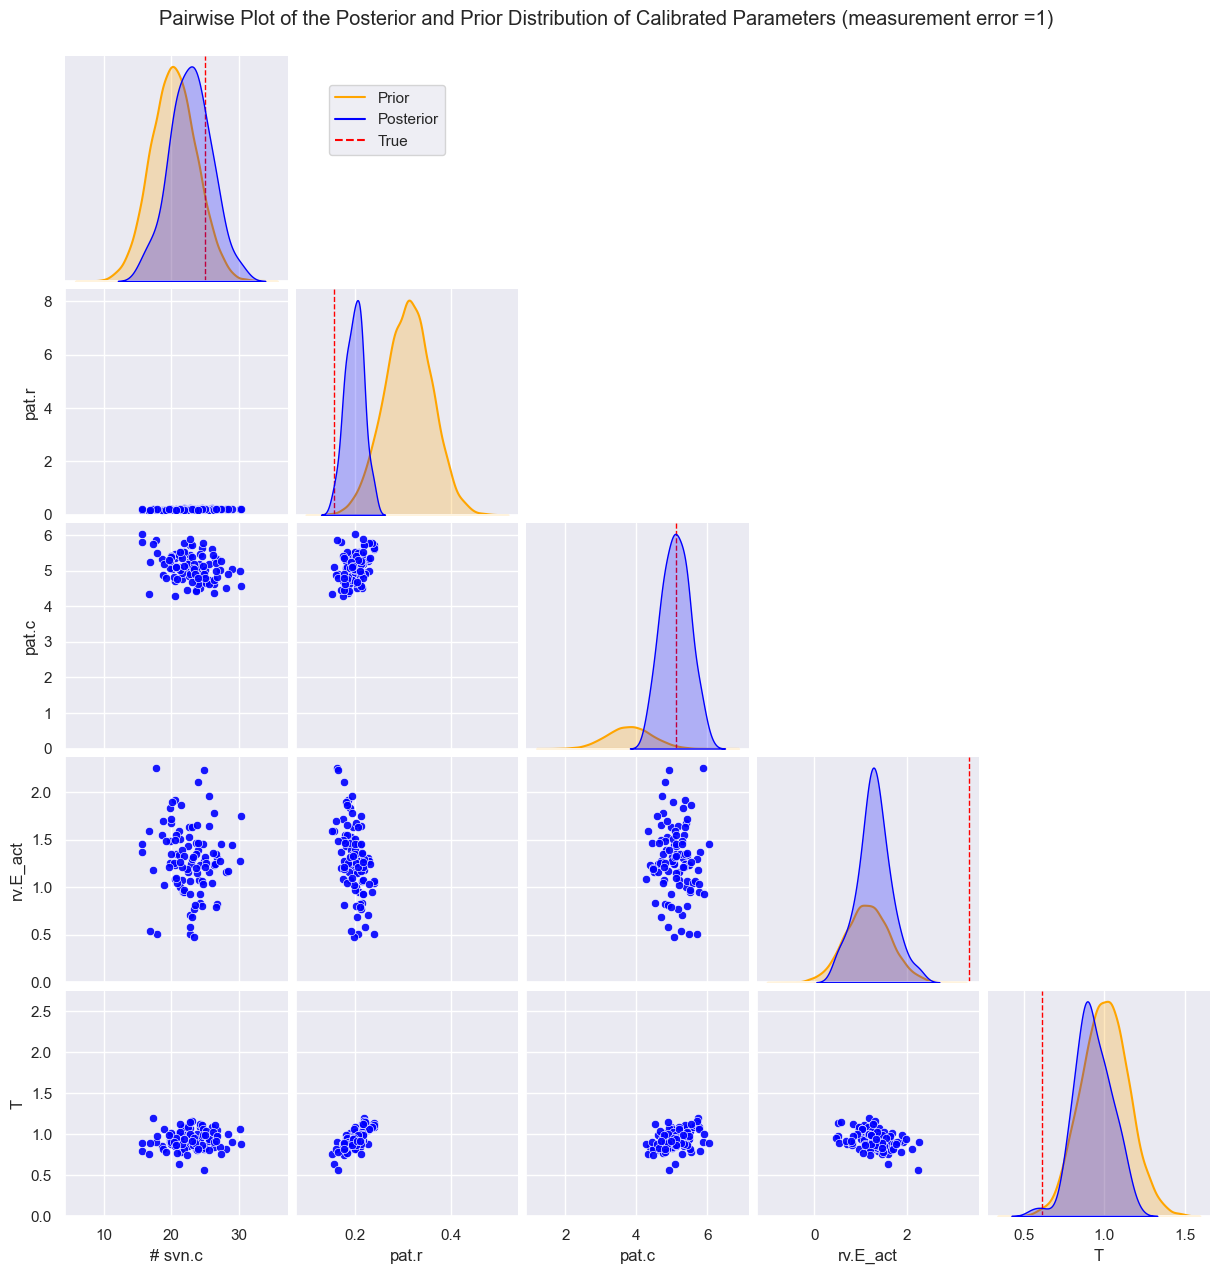

In [29]:
from matplotlib.lines import Line2D

# Define the prior mean and covariance 
mu_prior = mu_0.copy().reshape(-1)
sigma_prior = Sigma_0.copy()

# Define the posterior mean (mu) and covariance matrix (sigma)
mu = Mu_post.reshape(-1)
sigma = Sigma_post

# True values of X
true_values = filtered_input.iloc[which_obs].T

parameter_names = mse_x_df.index.values.tolist()

# Generate random samples
rng = np.random.default_rng(1)  # Using your specific random generator seed
samples = rng.multivariate_normal(mu, sigma, size=100)   ### sigma is a variance matrix 
prior_samples = rng.multivariate_normal(mu_prior, sigma_prior, size=10000)

# Convert samples to a DataFrame for pairplot visualization
columns = [f"X{i+1}" for i in range(len(mu))]
df = pd.DataFrame(samples, columns=parameter_names)

# Pairplot visualization
sns.set(style="darkgrid")
g = sns.pairplot(df, diag_kind='kde', plot_kws={"color": "blue", "alpha": 0.9}, diag_kws={"color": "blue"}, corner=True)


# Add dashed lines to each diagonal plot
for i, ax in enumerate(np.diag(g.axes)):
    # Add true value line
    ax.axvline(true_values.iloc[i], color='red', linestyle='--', linewidth=1)
    
    # Calculate and plot the prior distribution's KDE
    sns.kdeplot(
        prior_samples[:, i], 
        ax=ax, 
        color="orange", 
        fill="orange",
        linestyle='-', 
        linewidth=1.5, 
        label='Prior'
    )
    
 #   # Plot the posterior distribution
  #  sns.kdeplot(
   #     df.iloc[:, i],
    #    ax=ax,
     #   color="blue",
      #  linestyle='-',
       # linewidth=1.5,
        #label='Posterior'
    #)
  

                  
prior_line = Line2D([0], [0], color='orange', linestyle='-', linewidth=1.5, label='Prior')
posterior_line = Line2D([0], [0], color='blue', linestyle='-', linewidth=1.5, label='Posterior')        
true_line = Line2D([0], [0], color='red', linestyle='--', linewidth=1.5, label='True')
# Add legend to the plot
ax.legend(handles=[prior_line, posterior_line, true_line], loc="upper left",  bbox_to_anchor=(-3, 5.05))

# Adjust the layout and add the title
plt.suptitle("Pairwise Plot of the Posterior and Prior Distribution of Calibrated Parameters (measurement error =1)", y=1.02)
plt.tight_layout()
plt.show()

Bayesian calibration of multiple observations and calculate MSE between true input value and the mean of the posterior distrubtion at each observation. 

In [30]:
## Define priors
# mean
c_svn_mu = 20.5
r_pat_mu = 0.31
c_pat_mu = 3.8
rv_mu = 1.15
t_mu = 1

# variances
c_svn_sd = 3.42**2
r_pat_sd = 0.05**2
c_pat_sd = 0.63**2
rv_sd = 0.48**2
t_sd = 0.15**2

mu_0 = np.array([c_svn_mu, r_pat_mu, c_pat_mu, rv_mu, t_mu])[:, np.newaxis]
Sd = [c_svn_sd, r_pat_sd, c_pat_sd, rv_sd, t_sd]
Sigma_0 = np.diag(Sd)

# Build beta matrix (d * p, where d is dimension of y_obs and p is dinemnsion of X)
beta_matrix = []
intercept = []

for index, row_entry in selected_rows.iterrows():
    model = row_entry['Model']
    coeffs = model.coef_[0]
    b0 = model.intercept_

    beta_matrix.append(coeffs)
    intercept.append(b0)

# Convert the list to a NumPy array
beta_matrix = np.array(beta_matrix)
intercept = np.array(intercept)

x_differences = []

for row in range(10):
 # Select observation and reshape to be (d, 1)
 Y_obs = np.array(combined_outptut_data.T[row])
 Y_obs = Y_obs.reshape(len(Y_obs), 1)
 
 # Scale observation by intercepts of models
 Y_scaled = Y_obs - intercept


 # Compute the posterior covariance
 Sigma_post_inv = (beta_matrix.T @ beta_matrix) + np.linalg.inv(Sigma_0)
 Sigma_post = np.linalg.inv(Sigma_post_inv)

 # Cmpute the posterior mean
 Mu_post = Sigma_post @ (beta_matrix.T @ Y_scaled + np.linalg.inv(Sigma_0) @ mu_0)

 # Compute squared-diff between true and calibrated x
 true = np.array(filtered_input.loc[row].T)
 true = true.reshape(5,1)
 diff = (Mu_post - true)**2 

 # Append arrary
 x_differences.append(diff)

# Compute MSE
bayes_mse_x = np.mean(np.hstack(x_differences), axis=1)

bayes_mse_x_df = pd.DataFrame(bayes_mse_x)
bayes_mse_x_df.columns = ['MSE']
bayes_mse_x_df.index = filtered_input.columns
bayes_mse_x_df.to_csv('bayes_MSE_multi_output_x.csv')

bayes_mse_x_df

,MSE
# svn.c,44.044008
pat.r,0.002097
pat.c,0.808101
rv.E_act,1.149479
T,0.074652


Comparison of MSE of bayesian calibration (above) and frequentist calibration (below)

In [31]:
mse_x_df

,MSE
# svn.c,4581.203286
pat.r,0.000582
pat.c,22.615799
rv.E_act,4.106932
T,0.663989


### Bayesian Calibration  Including 5% observation error

In [32]:
obs_error = np.std(combined_outptut_data)*0.05
epsilon = np.diag(obs_error)
epsilon

 /opt/anaconda3/envs/ModularCirc/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning:The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


array([[0.48338167, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.11047518, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.06046192, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.0170343 , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.25041828]])

In [33]:
true_error = combined_outptut_data['PC1']*0.01

<Axes: xlabel='PC1', ylabel='Density'>

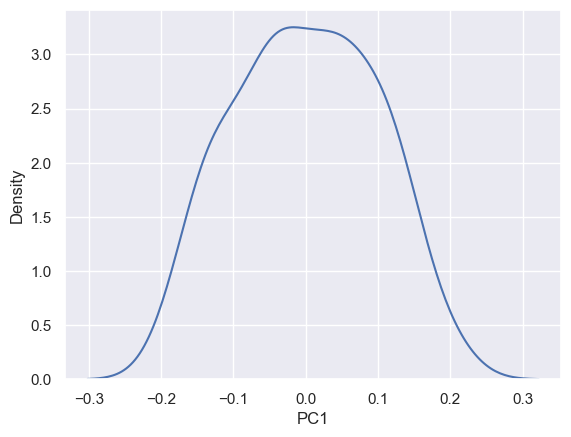

In [34]:
sns.kdeplot(true_error)

<Axes: ylabel='Density'>

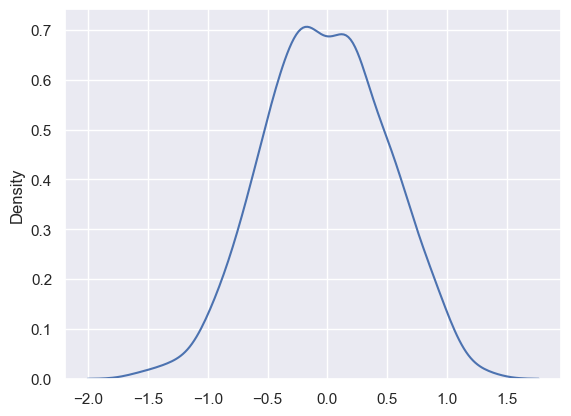

In [35]:
random_errors = np.random.normal(0, np.std(combined_outptut_data['PC1']*0.05),500) #scale is std not variance
sns.kdeplot(random_errors)

In [36]:
## Define priors
# mean
c_svn_mu = 20.5
r_pat_mu = 0.31
c_pat_mu = 3.8
rv_mu = 1.15
t_mu = 1

# variances
c_svn_sd = 3.42**2
r_pat_sd = 0.05**2
c_pat_sd = 0.63**2
rv_sd = 0.48**2
t_sd = 0.15**2

mu_0 = np.array([c_svn_mu, r_pat_mu, c_pat_mu, rv_mu, t_mu])[:, np.newaxis]
Sd = [c_svn_sd, r_pat_sd, c_pat_sd, rv_sd, t_sd]
Sigma_0 = np.diag(Sd)

epsilon_inv = np.linalg.inv(epsilon)

# Build beta matrix (d * p, where d is dimension of y_obs and p is dimension of X)
beta_matrix = []
intercept = []

# Selects which observation to calibrate on
which_obs = 3

for index, row_entry in selected_rows.iterrows():
    model = row_entry['Model']
    coeffs = model.coef_[0]
    b0 = model.intercept_

    beta_matrix.append(coeffs)
    intercept.append(b0)

# Convert the list to a NumPy array
beta_matrix = np.array(beta_matrix)
intercept = np.array(intercept)

# Select observation and reshape to be (d, 1)
Y_obs = np.array(combined_outptut_data.T[which_obs])
Y_obs = Y_obs.reshape(len(Y_obs), 1)

# Scale observation by intercepts of models
Y_scaled = Y_obs - intercept

# Compute the posterior covariance
Sigma_post_inv = ((beta_matrix.T @ epsilon_inv) @ beta_matrix) + np.linalg.inv(Sigma_0)
Sigma_post = np.linalg.inv(Sigma_post_inv)

# Cmpute the posterior mean
Mu_post = Sigma_post @ (beta_matrix.T @ epsilon_inv @ Y_scaled + np.linalg.inv(Sigma_0) @ mu_0)


In [37]:
# Convert the calibrated inputs to a DataFrame
Mu_post_df = pd.DataFrame(Mu_post, index=filtered_input.iloc[which_obs].T.index)

# Concatenate the true input value and calibrated values
bayes_result = pd.concat([filtered_input.iloc[which_obs].T, Mu_post_df], axis=1)

(bayes_result.iloc[: , 0] - bayes_result.iloc[:, 1])**2


# svn.c     21.926976
pat.r        0.000068
pat.c        0.016042
rv.E_act     1.298473
T            0.018283
dtype: float64

In [50]:
# Convert covariance matrix to correlation matrix
D = np.diag(1/np.sqrt(np.diag(Sigma_post)))
correlation_matrix = pd.DataFrame(D @ Sigma_post @ D)
correlation_matrix


,0,1,2,3,4
0,1.000000,0.271377,-0.619023,0.345706,-0.440105
1,0.271377,1.000000,0.384269,-0.317929,0.533551
2,-0.619023,0.384269,1.000000,-0.346631,0.717808
3,0.345706,-0.317929,-0.346631,1.000000,-0.485205
4,-0.440105,0.533551,0.717808,-0.485205,1.000000


In [58]:
U, D, V = np.linalg.svd(Sigma_post)
pd.DataFrame(D)

,0
0,9.720697
1,0.054411
2,0.035083
3,0.001501
4,0.000031


 /var/folders/28/nchybyxs1ps5wk3zmnqdpd8r0000gr/T/ipykernel_81837/719077307.py:57: UserWarning:Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


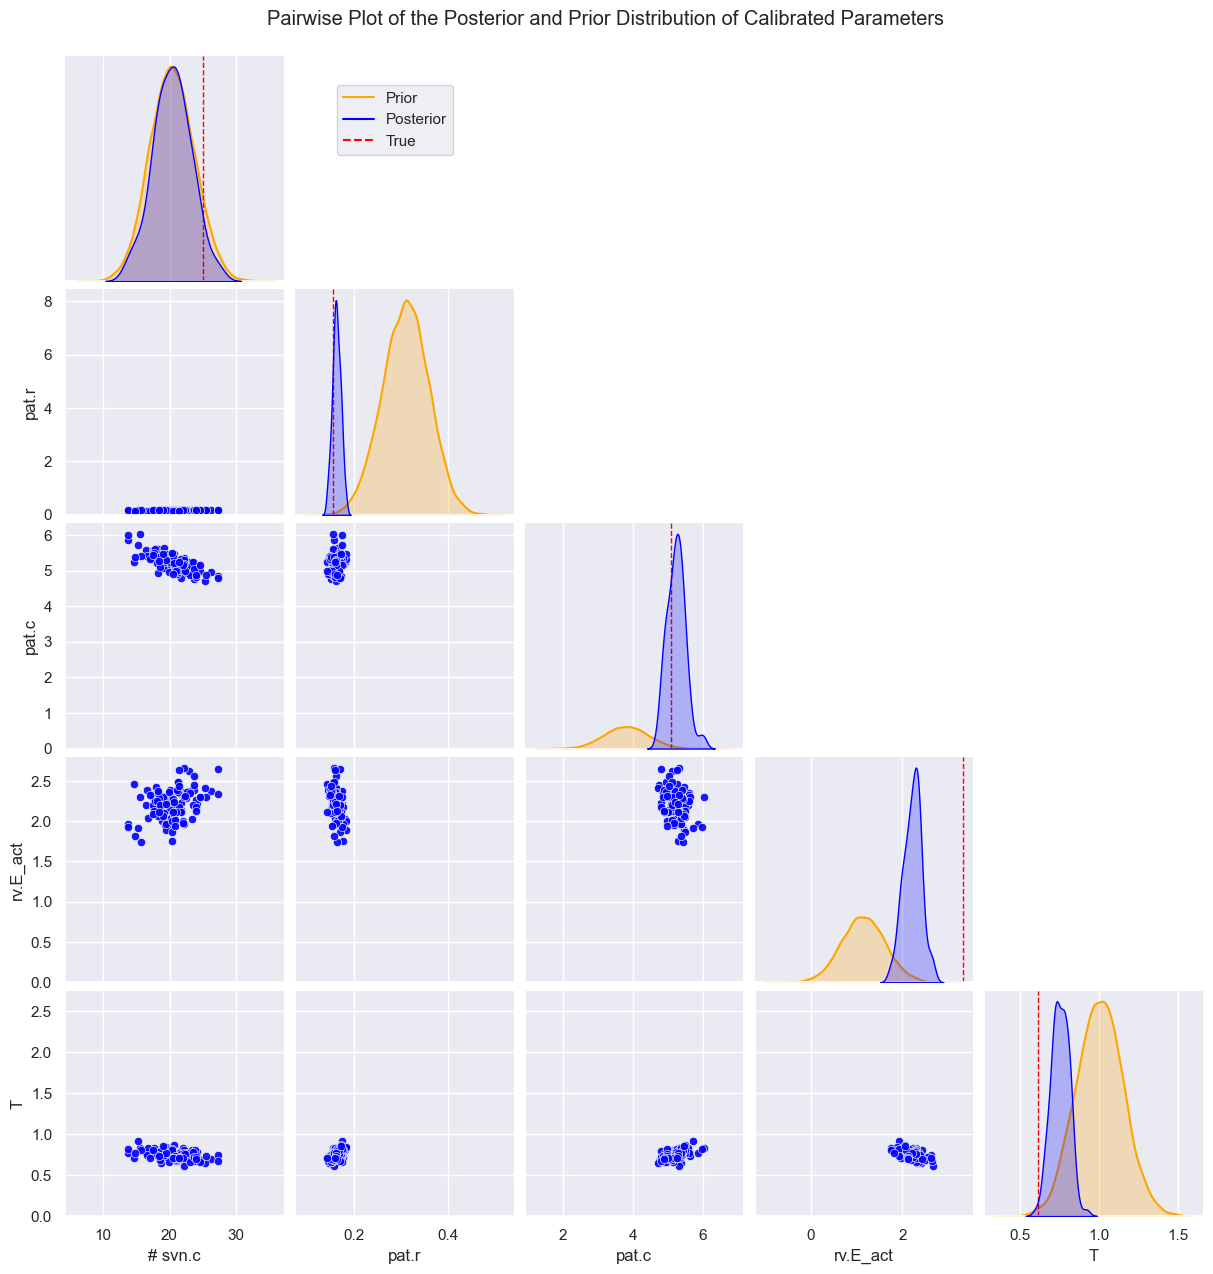

In [59]:
from matplotlib.lines import Line2D

# Define the prior mean and covariance 
mu_prior = mu_0.copy().reshape(-1)
sigma_prior = Sigma_0.copy()

# Define the posterior mean (mu) and covariance matrix (sigma)
mu = Mu_post.reshape(-1)
sigma = Sigma_post

# True values of X
true_values = filtered_input.iloc[which_obs].T

parameter_names = mse_x_df.index.values.tolist()

# Generate random samples
rng = np.random.default_rng(1)  # Using your specific random generator seed
samples = rng.multivariate_normal(mu, sigma, size=100)   ### sigma is a variance matrix 
prior_samples = rng.multivariate_normal(mu_prior, sigma_prior, size=10000)

# Convert samples to a DataFrame for pairplot visualization
columns = [f"X{i+1}" for i in range(len(mu))]
df = pd.DataFrame(samples, columns=parameter_names)

# Pairplot visualization
sns.set(style="darkgrid")
g = sns.pairplot(df, diag_kind='kde', plot_kws={"color": "blue", "alpha": 0.9}, diag_kws={"color": "blue"}, corner=True)


# Add dashed lines to each diagonal plot
for i, ax in enumerate(np.diag(g.axes)):
    # Add true value line
    ax.axvline(true_values.iloc[i], color='red', linestyle='--', linewidth=1)
    
    # Calculate and plot the prior distribution's KDE
    sns.kdeplot(
        prior_samples[:, i], 
        ax=ax, 
        color="orange", 
        fill="orange",
        linestyle='-', 
        linewidth=1.5, 
        label='Prior'
    )
    
      

                  
prior_line = Line2D([0], [0], color='orange', linestyle='-', linewidth=1.5, label='Prior')
posterior_line = Line2D([0], [0], color='blue', linestyle='-', linewidth=1.5, label='Posterior')        
true_line = Line2D([0], [0], color='red', linestyle='--', linewidth=1.5, label='True')
# Add legend to the plot
ax.legend(handles=[prior_line, posterior_line, true_line], loc="upper left",  bbox_to_anchor=(-3, 5.05))

# Adjust the layout and add the title
plt.suptitle("Pairwise Plot of the Posterior and Prior Distribution of Calibrated Parameters", y=1.02)
plt.tight_layout()
plt.show()

In [42]:
pd.DataFrame(Sigma_post)

,0,1,2,3,4
0,9.684314,0.009318,-0.539575,0.228638,-0.082911
1,0.009318,0.000122,0.001188,-0.000746,0.000356
2,-0.539575,0.001188,0.078455,-0.020634,0.012171
3,0.228638,-0.000746,-0.020634,0.045166,-0.006242
4,-0.082911,0.000356,0.012171,-0.006242,0.003665
